<a href="https://colab.research.google.com/github/jairramirez365/Aprendizaje-supervisado/blob/main/Actividad_Computer_Vision_C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

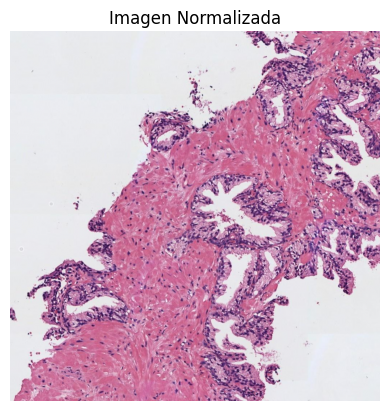

In [173]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = io.imread('/media/histo_1.jpg')
rgb = img.copy()
rgb_p = rgb.astype('uint8')/255

plt.imshow(rgb_p)
plt.title('Imagen Normalizada')
plt.axis('off')  # Oculta los ejes
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

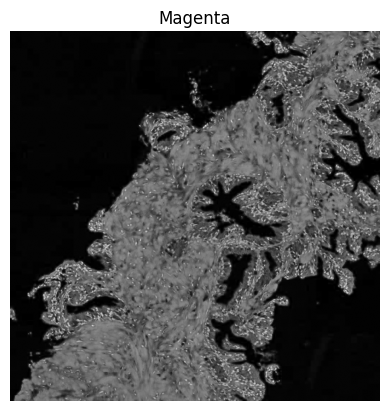

In [174]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

# Separar los canales RGB
R = rgb_p[:, :, 0]
G = rgb_p[:, :, 1]
B = rgb_p[:, :, 2]

# Calcular K
K = 1 - np.max(rgb_p, axis=2)

# Evitar división por cero
with np.errstate(invalid='ignore', divide='ignore'):
    C = (1 - R - K) / (1 - K)
    M = (1 - G - K) / (1 - K)
    Y = (1 - B - K) / (1 - K)

# Reemplazar NaNs con 0 (ocurre donde K = 1)
M[np.isnan(M)] = 0


# Empaquetar CMYK para visualizar (escalado de 0 a 255)
CMYK = (np.dstack((C, M, Y, K)) * 255).astype('uint8')

# Separar canales para visualización
C_img, M_img, Y_img, K_img = cv2.split(CMYK)

# Visualización
plt.imshow(M_img, cmap='gray')
plt.title('Magenta')
plt.axis('off')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

Valores únicos en la máscara: [0 1]


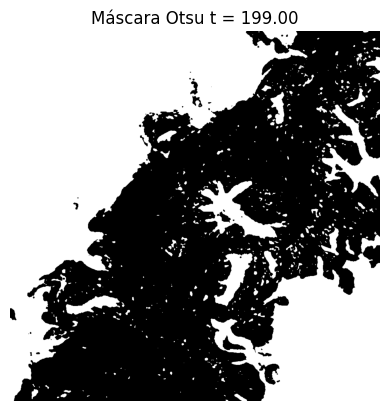

In [175]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

# gray_img = cv2.cvtColor(M_img, cv2.COLOR_RGB2GRAY)
M_inverted = 255 - M_img  # Invertir para que lúmenes (claros) sean blancos
# Aplicar filtro gaussiano 5x5
blur = cv2.GaussianBlur(M_inverted, (5, 5), 0)

# Aplicar método de Otsu (salida: umbral t y máscara binaria)
t, mask = cv2.threshold(blur, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Mostrar valores únicos en la máscara
print("Valores únicos en la máscara:", np.unique(mask))

# Visualizar la máscara
plt.imshow(mask, cmap='gray')
plt.title(f'Máscara Otsu t = {t:.2f}')
plt.axis('off')
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

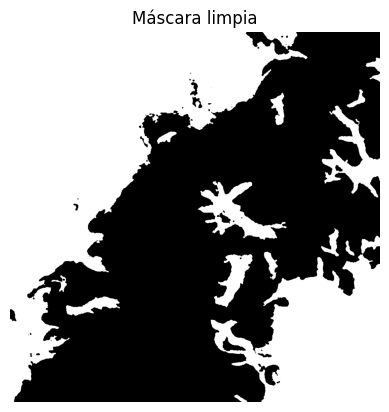

In [176]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

from skimage.morphology import remove_small_objects

#Convertir la máscara a booleano (True=1, False=0)
mask_bool = mask.astype(bool)

#Eliminar objetos pequeños (área < 300 píxeles)
mask_cleaned = remove_small_objects(mask_bool, min_size=300)

#Visualizar la máscara limpia
plt.imshow(mask_cleaned, cmap='gray')
plt.title('Máscara limpia')
plt.axis('off')
plt.show()


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

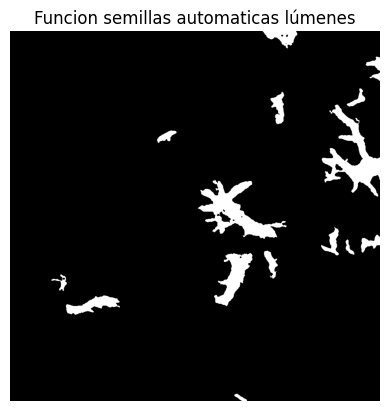

In [198]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.
from skimage.segmentation import flood

def obtener_lumines_por_region_growing(mascara_binaria, radio_max=15, area_min=10):
    etiquetas = label(mascara_binaria)
    regiones = regionprops(etiquetas)
    mascara_final = np.zeros_like(mascara_binaria, dtype=bool)

    for region in regiones:
        if region.area >= area_min:
            centroide = tuple(map(int, region.centroid))
            for r in range(-radio_max, radio_max + 1):
                for c in range(-radio_max, radio_max + 1):
                    rr, cc = centroide[0] + r, centroide[1] + c
                    if (0 <= rr < mascara_binaria.shape[0] and
                        0 <= cc < mascara_binaria.shape[1] and
                        mascara_binaria[rr, cc]):
                        crecida = flood(mascara_binaria, (rr, cc))
                        if np.sum(crecida) > area_min:
                            mascara_final |= crecida
                            break

    return mascara_final


def eliminar_regiones_en_borde_inferior_derecho(mask_bool, umbral_area=100000):
    etiquetas = label(mask_bool)
    mask_filtrada = mask_bool.copy()
    h, w = mask_bool.shape

    for region in regionprops(etiquetas):
        minr, minc, maxr, maxc = region.bbox
        en_borde_inferior = maxr == h
        en_borde_derecho = maxc == w
        if region.area > umbral_area and (en_borde_inferior or en_borde_derecho):
            mask_filtrada[etiquetas == region.label] = 0

    return mask_filtrada


mask_uint8 = (mask_cleaned.astype(np.uint8)) * 255

# Rellenar el fondo con negro desde la esquina superior izquierda
h, w = mask_uint8.shape
ref = np.zeros((h + 2, w + 2), np.uint8)
cv2.floodFill(mask_uint8, ref, (0, 0), 0)

# Convertir a booleano
mask_bool = mask_uint8.astype(bool)

# Eliminar solo regiones muy grandes conectadas al borde inferior o derecho
mask_filtrada = eliminar_regiones_en_borde_inferior_derecho(mask_bool)

# Aplicar region growing
lumen_resultado = obtener_lumines_por_region_growing(mask_filtrada.astype(np.uint8) * 255)

plt.imshow(lumen_resultado, cmap='gray')
plt.title('Funcion semillas automaticas lúmenes')
plt.axis('off')
plt.show()


#### 5) Rellenar los objetos de los lúmenes

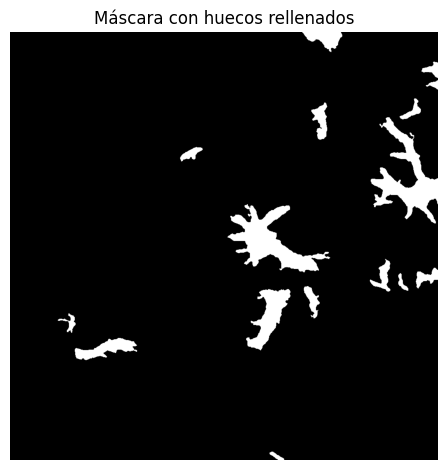

In [178]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

from scipy.ndimage import binary_fill_holes

# Paso 2: Rellenar huecos dentro de los lúmenes
mask_rellena = binary_fill_holes(lumen_resultado)

plt.imshow(mask_rellena, cmap='gray')
plt.title('Máscara con huecos rellenados')
plt.axis('off')
plt.tight_layout()
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

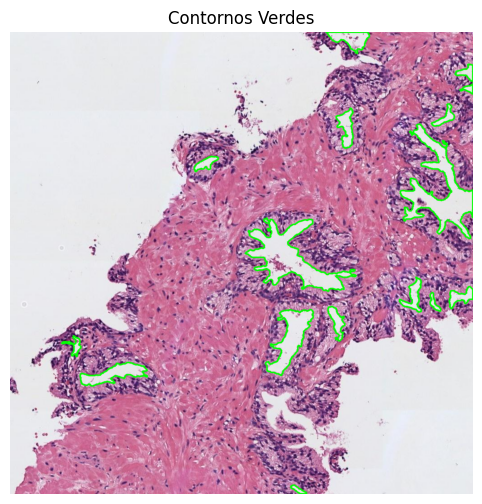

In [200]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta


mask_rellena = mask_rellena.astype(np.uint8) * 255
contornos, _ = cv2.findContours(mask_rellena, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Dibujar contornos en verde sobre copia de imagen original
imagen_bgr = cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_RGB2BGR)  # Asegura formato OpenCV
imagen_con_contornos = imagen_bgr.copy()
cv2.drawContours(imagen_con_contornos, contornos, -1, (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(imagen_con_contornos, cv2.COLOR_BGR2RGB))
plt.title('Contornos Verdes')
plt.axis('off')



#### 7) Identificar y cropear el lumen más grande

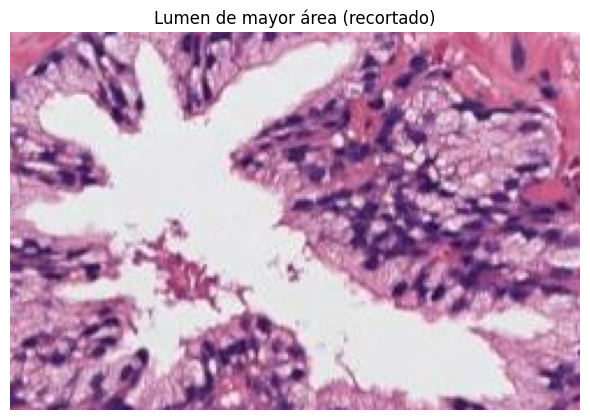

In [180]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

areas = [cv2.contourArea(c) for c in contornos]
idx_max = np.argmax(areas)
contorno_max = contornos[idx_max]

# Obtener bounding box y hacer crop
x, y, w, h = cv2.boundingRect(contorno_max)

# Crop del lumen mayor
lumen_crop = img[y:y+h, x:x+w]

plt.figure(figsize=(6, 6))
plt.imshow(lumen_crop)
plt.title('Lumen de mayor área (recortado)')
plt.axis('off')
plt.tight_layout()
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [197]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

import math
from tabulate import tabulate
from scipy.spatial.distance import pdist


mask_bool = lumen_crop[..., 0] > 0  # Asume que lumen_crop es imagen RGB del crop
label_img = label(mask_bool)

# Obtener todas las regiones
regions = regionprops(label_img)

# Seleccionar la región de mayor área
max_region = max(regions, key=lambda x: x.area)

# Obtener propiedades desde el contorno ya conocido (contorno_max)
area = cv2.contourArea(contorno_max)
x, y, w, h = cv2.boundingRect(contorno_max)
bounding_box_area = w * h
perimeter = cv2.arcLength(contorno_max, True)

# Crear una máscara para esta región y calcular propiedades avanzadas
mask_crop = np.zeros((h, w), dtype=np.uint8)
contorno_offset = contorno_max - [x, y]  # ajustar coordenadas al crop
cv2.drawContours(mask_crop, [contorno_offset], -1, 1, -1)  # relleno

# Propiedades usando regionprops sobre la máscara del crop
from skimage.measure import label, regionprops

region = regionprops(label(mask_crop))[0]

# Calcular propiedades geométricas
A = round(region.area, 4)
BB = round(region.bbox_area, 4)
CA = round(region.convex_area, 4)
E = round(region.eccentricity, 4)
ED = round(np.sqrt(4 * region.area / np.pi), 4)
EX = round(region.extent, 4)
FD = round(np.max(pdist(contorno_max[:, 0, :])), 4)
MA = round(region.major_axis_length, 4)
MiA = round(region.minor_axis_length, 4)
OR = round(region.orientation, 4)
P = round(region.perimeter, 4)
S = round(region.solidity, 4)
CO = round(4 * math.pi * region.area / (region.perimeter ** 2), 4)
R = round(region.area / region.bbox_area, 4)

# Mostrar la tabla
headers = ["Propiedad", "Valor"]
data = [
    ["Área", A],
    ["Área bounding box", BB],
    ["Área convexa", CA],
    ["Excentricidad", E],
    ["Diámetro equivalente",ED],
    ["Extensión", EX],
    ["Diámetro Feret", FD],
    ["Longitud del eje mayor", MA],
    ["Longitud del eje menor", MiA],
    ["Orientación", OR],
    ["Perímetro", P],
    ["Solidez", S],
    ["Compacidad", CO],
]

print(tabulate(data, headers=headers, tablefmt="grid"))


+------------------------+------------+
| Propiedad              |      Valor |
+========================+============+
| Área                   | 14110      |
+------------------------+------------+
| Área bounding box      | 40098      |
+------------------------+------------+
| Área convexa           | 29267      |
+------------------------+------------+
| Excentricidad          |     0.847  |
+------------------------+------------+
| Diámetro equivalente   |   134.035  |
+------------------------+------------+
| Extensión              |     0.3519 |
+------------------------+------------+
| Diámetro Feret         |   258.155  |
+------------------------+------------+
| Longitud del eje mayor |   238.527  |
+------------------------+------------+
| Longitud del eje menor |   126.796  |
+------------------------+------------+
| Orientación            |     1.0052 |
+------------------------+------------+
| Perímetro              |  1238.32   |
+------------------------+------------+
